In [1]:
using Pkg
Pkg.activate(".")
using JSON
using WordTokenizers
using StatsBase
using Flux,CuArrays
using Flux:onehot
using Base.Iterators:partition
using Metalhead
using JLD
using BSON:@save,@load

include("utils.jl")
BASE_PATH = "../data/"
NUM_SENTENCES = 30000
K = 5000

5000

In [2]:
# Load the models
@load "cnn_encoder.bson" cnn_encoder
@load "embedding.bson" embedding
@load "rnn_decoder.bson" rnn_decoder
@load "decoder.bson" decoder

In [3]:
vgg = VGG19() 
Flux.testmode!(vgg)
vgg = vgg.layers[1:end-3]

Chain(Conv((3, 3), 3=>64, NNlib.relu), Conv((3, 3), 64=>64, NNlib.relu), getfield(Metalhead, Symbol("##42#48"))(), Conv((3, 3), 64=>128, NNlib.relu), Conv((3, 3), 128=>128, NNlib.relu), getfield(Metalhead, Symbol("##43#49"))(), Conv((3, 3), 128=>256, NNlib.relu), Conv((3, 3), 256=>256, NNlib.relu), Conv((3, 3), 256=>256, NNlib.relu), Conv((3, 3), 256=>256, NNlib.relu), getfield(Metalhead, Symbol("##44#50"))(), Conv((3, 3), 256=>512, NNlib.relu), Conv((3, 3), 512=>512, NNlib.relu), Conv((3, 3), 512=>512, NNlib.relu), Conv((3, 3), 512=>512, NNlib.relu), getfield(Metalhead, Symbol("##45#51"))(), Conv((3, 3), 512=>512, NNlib.relu), Conv((3, 3), 512=>512, NNlib.relu), Conv((3, 3), 512=>512, NNlib.relu), Conv((3, 3), 512=>512, NNlib.relu), getfield(Metalhead, Symbol("##46#52"))(), getfield(Metalhead, Symbol("##47#53"))(), Dense(25088, 4096, NNlib.relu), Dropout{Float32}(0.5f0, false), Dense(4096, 4096, NNlib.relu))

In [4]:
word2idx = load("word2idx.jld")["word2idx"]
idx2word = load("idx2word.jld")["idx2word"]

Dict{Int64,String} with 5002 entries:
  3194 => "master"
  2843 => "treats"
  4495 => "nuzzle"
  1760 => "competing"
  306  => "WITH"
  3339 => "AROUND"
  1316 => "soccer"
  4621 => "tubes"
  4473 => "lounges"
  4460 => "lacking"
  1333 => "Interior"
  4517 => "fits"
  3485 => "love"
  3120 => "wading"
  1671 => "Police"
  1131 => "tracks"
  3180 => "dressing"
  3170 => "should"
  2553 => "staff"
  2126 => "Photo"
  74   => "red"
  1662 => "canoe"
  1265 => "SMALL"
  4163 => "knocked"
  3064 => "depicts"
  ⋮    => ⋮

In [5]:
onehotword(word) = Float32.(onehot(word2idx[word],1:length(keys(word2idx))))

function reset(rnn_decoder)
    Flux.reset!(rnn_decoder)
end

reset (generic function with 1 method)

In [6]:
function sample(image_path)
    img = Metalhead.preprocess(load(image_path))
    features = vgg(img)
    
    reset(rnn_decoder)
    prev_word = "<s>"
    lstm_inp = cnn_encoder(features)
    lstm_out = rnn_decoder(lstm_inp)
    output = ""
    
    for i in 1:15
        output = string(output," ",prev_word)
        if prev_word == "</s>"
            break
        end
        word_embeddings = embedding(onehotword(prev_word))
        predictions = softmax(decoder(rnn_decoder(word_embeddings)))
        next_word = idx2word[Flux.argmax(predictions)[1]]
        prev_word = next_word
    end
    
    output
end

sample (generic function with 1 method)

┌ Warning: `argmax(...) is deprecated, use `onecold(...)` instead.
│   caller = sample(::String) at In[6]:18
└ @ Main ./In[6]:18


 <s> A young man is walking his bicycle across the street </s>


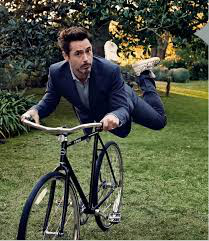

In [8]:
image_name = "1.jpeg"
println(sample(image_name))
load(image_name)

 <s> A man is taking a picture of a video game in a kitchen </s>


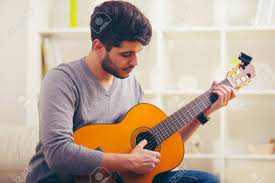

In [9]:
image_name = "2.jpeg"
println(sample(image_name))
load(image_name)

 <s> A person taking a picture on a small stone </s>


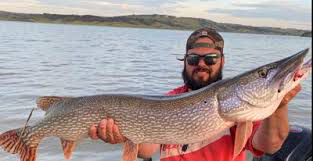

In [15]:
image_name = "4.jpeg"
println(sample(image_name))
load(image_name)

 <s> A kitchen with a sink and a refrigerator </s>


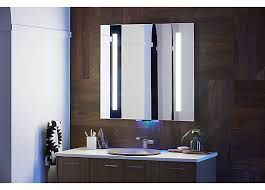

In [17]:
image_name = "5.jpeg"
println(sample(image_name))
load(image_name)

 <s> A group of men with his cap next to a woman in a kitchen


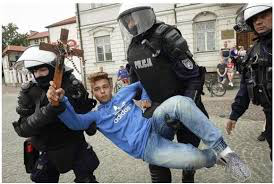

In [23]:
image_name = "6.jpeg"
println(sample(image_name))
load(image_name)